# MLDB: Insight Demo

In [222]:
# Standard scientific Python imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# general python imports
import time
import urllib3
import mysql.connector
from bs4 import BeautifulSoup
import requests
import pickle


# import datasets, preprocessing, evaluation
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import variation
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.learning_curve import validation_curve
from sklearn.learning_curve import learning_curve

# Supervised learning
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.random_projection import SparseRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# clustering
from sklearn.cluster import KMeans

# set plots inline for ipython
%matplotlib inline

In [223]:
# set up db connection
db = mysql.connector.connect(
         user='root',
         password='root',
         host='localhost',
         database='mlmodel_db')

cur = db.cursor()

## 1. Extract and parse dataset info from UCI ML Repository and save it to the database

In [224]:
# set up extraction variables
dailyMax = 200
batchNum = 20
sleeptime = 2

# Get dataset name and link
cur.execute('SELECT dataset_name, link FROM dataset ORDER BY dataset_name ASC')
rows = cur.fetchall()

In [226]:
def extract_info(row):
    """
    Extract dataset info for each row from UCI repository
    
    :type row: tuple
    :rtype: pandas DataFrame
    """
    
    # Get dataset name and link
    dataset_name = row[0].encode('ascii','ignore') # unicode to ascii
    url = row[1].encode('ascii','ignore') # unicode to ascii
    
    # Extract web data
    time.sleep(sleeptime) # sleep 5 sec between each extraction
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    # Parse data to fetch Abstract, Number of Attributes, Number of Instance, Data Type
    normal = soup.find_all(class_='normal')
    abstract = normal[2].get_text()
    data_type = normal[4].get_text()
    instance_number = normal[6].get_text()
    attribute_number = normal[12].get_text()
    
    info = pd.DataFrame({
        "dataset_name": [dataset_name],
        "abstract": [abstract], 
        "data_type": [data_type], 
        "instance_number": [instance_number], 
        "attribute_number": [attribute_number]
    })
    
    return info

In [227]:
# Extract all dataset info and save them to mlmodel_db
for i in range(len(rows)):
    dataset_name = rows[i][0].encode('ascii','ignore') # unicode to ascii
    print 'Updating: ' + dataset_name + ' ...'

    info = extract_info(rows[i])
    abstract = info['abstract'].iloc[0]
    attribute_number = info['attribute_number'].iloc[0]
    instance_number = info['instance_number'].iloc[0]
    data_type = info['data_type'].iloc[0]
    
    # load data into the Dataset table in MySQL mlmodel_db
    #update_dataset_sql = 'UPDATE Dataset SET abstract = "' + abstract + '"'
    
    update_dataset_sql = 'UPDATE Dataset SET abstract = "' + abstract + '",'\
                         'attribute_number = ' + attribute_number + ','\
                         'instance_number = ' + instance_number + ','\
                         'data_type = "' + data_type + '" ' +\
                         'WHERE dataset_name = "' + dataset_name + '"'
    
    try:
        cur.execute(update_dataset_sql)
        db.commit()
    except:
        db.rollback()

print "Extraction and updating completed."

Updating: Breast Cancer ...
Updating: Pima Indians Diabetes ...
Updating: StarCraft2 Replay ...
Extraction and updating completed.


## 2. Build Machine Learning Models For Breast Cancer Dataset

### 2.1 Data Exploration and Preprocessing

In [228]:
# load data
cancer=pd.read_csv('breast-cancer-w-diag.csv', header=0)
cancer.drop('id',axis=1,inplace=True)
cancer.drop('Unnamed: 32',axis=1,inplace=True)
cancer['diagnosis'] = cancer['diagnosis'].map({'M':1,'B':0})

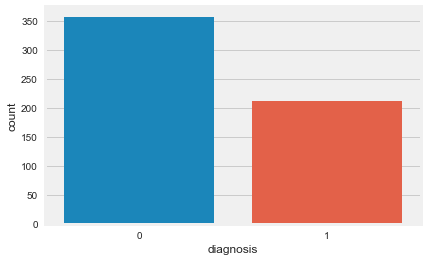

In [229]:
#cancer.isnull().sum() # check missing value
sns.countplot(x='diagnosis',data=cancer)
plt.show()

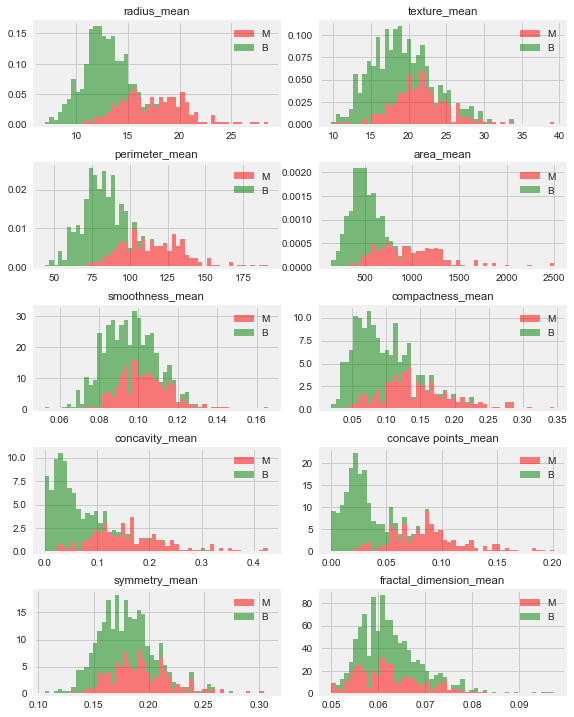

In [230]:
# visualize nucleus features vs diagnosis

features_mean=list(cancer.columns[1:11])
# split dataframe into two based on diagnosis
dfM=cancer[cancer['diagnosis'] ==1]
dfB=cancer[cancer['diagnosis'] ==0]

#Stack the data
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8,10))
axes = axes.ravel()
for idx,ax in enumerate(axes):
    ax.figure
    binwidth= (max(cancer[features_mean[idx]]) - min(cancer[features_mean[idx]]))/50
    ax.hist([dfM[features_mean[idx]],dfB[features_mean[idx]]], bins=np.arange(min(cancer[features_mean[idx]]), max(cancer[features_mean[idx]]) + binwidth, binwidth) , alpha=0.5,stacked=True, normed = True, label=['M','B'],color=['r','g'])
    ax.legend(loc='upper right')
    ax.set_title(features_mean[idx])
plt.tight_layout()
plt.show()

In [231]:
# Split training and testing set
train,test=train_test_split(cancer,test_size=0.2,random_state=0,stratify=cancer['diagnosis'])# stratify the outcome
train_X=train[train.columns[1:31]]
test_X=test[test.columns[1:31]]
train_Y=train['diagnosis']
test_Y=test['diagnosis']

In [232]:
# Scale data

# fit a standardScaler to normalize all input to zero mean and unit variance
scaler = StandardScaler().fit(train_X)
train_X = pd.DataFrame(scaler.transform(train_X), columns = train_X.columns)
test_X = pd.DataFrame(scaler.transform(test_X), columns = test_X.columns)

In [233]:
train_X.head(2)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-0.862083,-1.009094,-0.861347,-0.786765,-1.158494,-0.615198,-0.654171,-0.707010,0.692286,-0.047962,...,-0.857701,-0.802311,-0.809130,-0.753108,-0.996486,-0.346704,-0.553743,-0.697964,0.481210,-0.604967
1,-0.944093,-0.999941,-0.959931,-0.835771,-1.296173,-0.978211,-0.811038,-1.031182,-1.503224,-0.836375,...,-0.886863,-0.820201,-0.866969,-0.763508,-1.079789,-0.830368,-0.824462,-1.197365,-0.972434,-0.886765


In [234]:
print train_X.shape
print test_X.shape

(455, 30)
(114, 30)


### 2.2 A simple decision tree demo

### Grid Search with CV to find DT parameters

In [235]:
# determine optimal pruning for the decision trees using cross-validation grid-search

# set of parameters to test
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 3, 4, 5, 6, 10, 20],
              "max_depth": [2, 3, 4, 5, 6, 7, 10, 15, 20],
              }

tree_gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                       param_grid=param_grid, cv=3)

tree_gs.fit(train_X, train_Y)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4, 5, 6, 10, 20], 'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 6, 7, 10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [236]:
tree_gs.best_params_

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}

In [237]:
# Get best estimator
tree_final_model = tree_gs.best_estimator_
start = time.time()
clf = tree_final_model.fit(train_X, train_Y)
stop = time.time()
train_time = stop - start

# train
train_Y_predict = clf.predict(train_X)
train_acc = accuracy_score(train_Y, train_Y_predict)

# test
test_Y_predict = clf.predict(test_X)
test_acc = accuracy_score(test_Y, test_Y_predict)

# print result
print 'train acc: ', train_acc
print 'test acc: ', test_acc
print 'train time: ', train_time

# get correct precision
test_acc_4 = "{:10.4f}".format(test_acc)
#print test_acc_4

train acc:  0.982417582418
test acc:  0.964912280702
train time:  0.0213301181793


### Save model to the database which can be revised later

In [246]:
# Save the model to disk using pickle
# Dump the trained decision tree classifier with Pickle
decision_tree_pkl_filename = 'decision_tree_model_20171107.pkl'
# Open the file to save as pkl file
decision_tree_model_pkl = open(decision_tree_pkl_filename, 'wb')
pickle.dump(tree_final_model, decision_tree_model_pkl)
# Close pickle
decision_tree_model_pkl.close()

# Save model_filename to the database
insert_model_sql = 'INSERT INTO Model (model_name, dataset_name, model_filename, score) VALUES (\
                   "decision-tree-1", "Breast Cancer","' + decision_tree_pkl_filename + '",' + test_acc_4 + ')'

try:
    cur.execute(insert_model_sql)
    db.commit()
except:
    db.rollback()

print "Saved a new model."

Saved a new model.


### Get saved model from database

In [247]:
# Get saved model_filename from database
#select_model_sql = 'SELECT model_filename FROM Model WHERE model_name = "decision-tree-1"'
select_model_sql = 'SELECT model_filename FROM Model WHERE score > 0.95'

cur.execute(select_model_sql)
rows = cur.fetchall()
    
filename = rows[0][0]
print filename
# Loading the saved decision tree model from disk
model_pkl = open(filename, 'rb')
model = pickle.load(model_pkl)
print model

decision_tree_model_20171107.pkl
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')


### Use saved model to do more analysis

In [152]:
# Tree structure and Testing
treeObj = decision_tree_model.tree_
test_Y_predict = decision_tree_model.predict(test_X)
test_acc = accuracy_score(test_Y, test_Y_predict)

# print result
print 'tree size: ', treeObj.node_count
print 'test acc: ', test_acc

tree size:  21
test acc:  0.964912280702


In [153]:
# learning curve
training_size, train_lc, val_lc = learning_curve(decision_tree_model,
                                         train_X, train_Y, cv=10,
                                         #train_sizes=np.arange(1, 409), n_jobs=1)
                                         train_sizes=np.linspace(0.001, 1, 50), n_jobs=1)

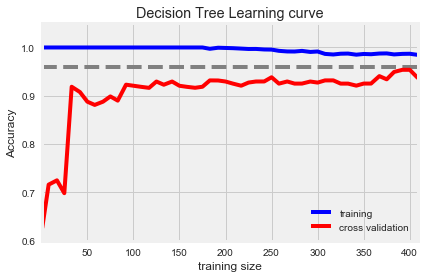

In [154]:
plt.plot(training_size, np.mean(train_lc, 1), color='blue', label='training')
plt.plot(training_size, np.mean(val_lc, 1), color='red', label='cross validation')
plt.hlines(np.mean([train_lc[-1], val_lc[-1]]), training_size[0], training_size[-1],
                 color='gray', linestyle='dashed')

plt.legend(loc='lower right')
plt.ylim(0.6, 1.05)
plt.xlim(training_size[0], training_size[-1])
plt.title("Decision Tree Learning curve")
plt.xlabel('training size')
plt.ylabel('Accuracy');
plt.show()

## 3. More Machine Learning Models

### 3.1 SVM hyperparameter tuning and overfitting

### svm - poly kernel, degree vs C

In [164]:
degree = range(1,11)
#degree = [1,2,3,4,5,7,10]
train_scores_svm1, val_scores_svm1 = validation_curve(svm.SVC(kernel='poly', C=0.01), train_X, train_Y,
                                          'degree', degree, cv=10)
train_scores_svm2, val_scores_svm2 = validation_curve(svm.SVC(kernel='poly', C=0.1), train_X, train_Y,
                                          'degree', degree, cv=10)
train_scores_svm3, val_scores_svm3 = validation_curve(svm.SVC(kernel='poly', C=1), train_X, train_Y,
                                          'degree', degree, cv=10)
train_scores_svm4, val_scores_svm4 = validation_curve(svm.SVC(kernel='poly', C=10), train_X, train_Y,
                                          'degree', degree, cv=10)

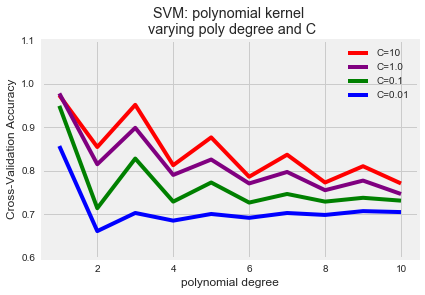

In [165]:
plt.plot(degree, np.mean(val_scores_svm4, 1), color='red', label='C=10')
plt.plot(degree, np.mean(val_scores_svm3, 1), color='purple', label='C=1.0')
plt.plot(degree, np.mean(val_scores_svm2, 1), color='green', label='C=0.1')
plt.plot(degree, np.mean(val_scores_svm1, 1), color='blue', label='C=0.01')

plt.legend(loc='upper right')
plt.ylim(0.6, 1.1)
plt.title("SVM: polynomial kernel \n varying poly degree and C")
plt.xlabel('polynomial degree')
plt.ylabel('Cross-Validation Accuracy');
plt.show()

### Hyperparameter - C

In [162]:
degree = np.logspace(-1.5, 3, 10)
train_scores, val_scores = validation_curve(svm.SVC(kernel='rbf'), train_X, train_Y,
                                          'C', degree, cv=10)

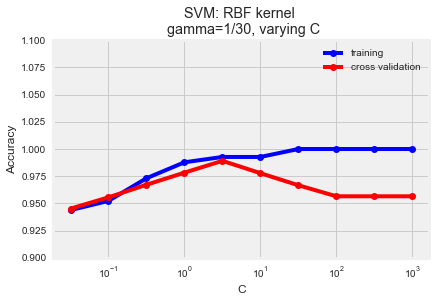

In [163]:
plt.plot(degree, np.median(train_scores, 1), 'o-',color='blue', label='training')
plt.plot(degree, np.median(val_scores, 1), 'o-', color='red', label='cross validation')

plt.legend(loc='upper right')
plt.ylim(0.9, 1.1)
plt.title("SVM: RBF kernel \n gamma=1/30, varying C")
plt.xlabel('C')
plt.ylabel('Accuracy');
plt.xscale('log')
plt.show()

### Hyperparameter - gamma

In [166]:
#degree = [0.0001,0.0003,0.001,0.003,0.01,0.03,0.1,0.3]
degree = np.logspace(-4, 1, 11)

train_scores, val_scores = validation_curve(svm.SVC(kernel='rbf'), train_X, train_Y,
                                          'gamma', degree, cv=10)

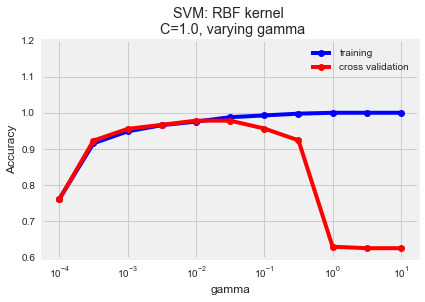

In [167]:
plt.plot(degree, np.median(train_scores, 1), 'o-',color='blue', label='training')
plt.plot(degree, np.median(val_scores, 1), 'o-', color='red', label='cross validation')

plt.legend(loc='upper right')
plt.ylim(0.6, 1.2)
plt.title("SVM: RBF kernel \n C=1.0, varying gamma")
plt.xlabel('gamma')
plt.ylabel('Accuracy');
plt.xscale('log')
plt.show()

### 3.2 Neural Networks and PCA

### Find Optimal Parameters

In [168]:
# hidden layers
# number of nodes in hidden layer
# learning rate
# momentum

In [169]:
# Best Parameters found by Grid Search of L and M
mlp_temp_model = MLPClassifier(hidden_layer_sizes=(22,),solver='sgd',learning_rate_init=0.1, 
                               momentum=0.5, max_iter=10000)
start = time.time()
clf = clf.fit(train_X, train_Y)
stop = time.time()
train_time = stop - start

# train
train_Y_predict = clf.predict(train_X)
train_acc = accuracy_score(train_Y, train_Y_predict)

# test
test_Y_predict = clf.predict(test_X)
test_acc = accuracy_score(test_Y, test_Y_predict)

# print result
print 'train acc: ', train_acc
print 'test acc: ', test_acc
print 'train time: ', train_time

train acc:  0.982417582418
test acc:  0.964912280702
train time:  0.00793218612671


### PCA

In [209]:
# fix name
X = train_X
y = np.array(train_Y)
X_test = test_X
y_test = np.array(test_Y)

In [210]:
# Choose PCA parameter: n_compoents
pca = PCA()
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [211]:
# Get Cummulative exp var
cummulative_explained_variance_ = np.cumsum(pca.explained_variance_ratio_)

# Get kNN Accuracy
acc = [] # accuracy
rmse_pca = [] # reconstruction error
for i in range (1, 31):
    pca = PCA(n_components=i)
    pca.fit(X)
    X_pca = pca.transform(X)
    X_projected = pca.inverse_transform(X_pca)
    mse = ((X - X_projected)**2).mean()
    rmse_pca.append(np.sqrt(mse))
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_pca, y)
    acc.append(clf.score(X_pca, y))

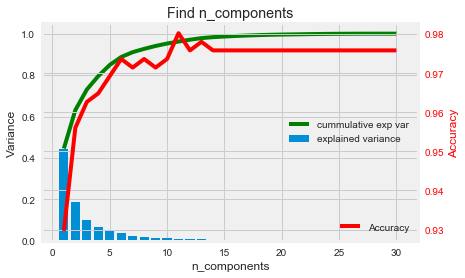

In [212]:
# Plot PCA Graph with Different n_omponents
fig, ax1 = plt.subplots()
x_range = range(1, 31)
ax1.bar(x_range, pca.explained_variance_ratio_, label='explained variance')
ax1.plot(x_range, cummulative_explained_variance_, color='green', label='cummulative exp var')
ax1.set_xlabel('n_components')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Variance')
ax1.legend(loc=5)

#ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(x_range, acc, color='red', label='Accuracy')
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc=4)

plt.title('Find n_components')
plt.show()

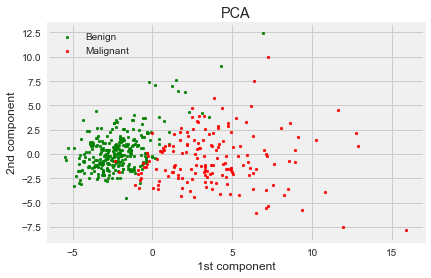

In [215]:
# Explore PCA's 1st and 2nd Components
# PCA Plot
X_pca = PCA(n_components=5).fit_transform(X)

k = 2 # number of clusters
colors = ['g', 'r', 'b', 'y', 'c', 'm']
labels = ['Benign', 'Malignant']

fig, ax = plt.subplots()
for i in range(k):
    points = np.array([X_pca[j] for j in range(len(X_pca)) if y[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=7, c=colors[i], label=labels[i])

plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.legend(loc=2)
plt.title('PCA')

### Neural Networks with PCA

In [217]:
# mlp learner helper function
def mlp_learner(input_layer_size, X_train, X_test):
    """
    The Neural Network (Multilayer Perceptron) helper function
    
    :type input_layer_size: int
    :type X_train: pandas DataFrame
    :type X_test: pandas DataFrame
    :rtype: void
    """
    
    # set learning_rate and momentum
    learning_rate = 0.1
    momentum = 0.5
    # hidden_layer_size = (input layer + output layer) / 2
    size = (input_layer_size + 2) / 2 
    
    # mlp classifier
    mlp = MLPClassifier(hidden_layer_sizes=(size,),
                        solver='sgd',
                        learning_rate_init=learning_rate, 
                        momentum=momentum,
                        max_iter=10000)
    start = time.time()
    clf = mlp.fit(X_train, y)
    train_time = time.time() - start

    # train
    y_predict = clf.predict(X_train)
    train_acc = accuracy_score(y, y_predict)

    # test
    y_test_predict = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_predict)
    
    # return
    return train_acc, test_acc, train_time

In [218]:
# Original MLP
train_acc, test_acc, train_time = mlp_learner(30, X, X_test)
print 'train acc: ', train_acc
print 'test acc: ', test_acc
print 'train time: ', train_time

train acc:  0.993406593407
test acc:  0.956140350877
train time:  0.260187864304


In [221]:
# PCA - MLP
pca = PCA(n_components=5)
pca.fit(X)
X_pca = pca.transform(X)
X_test_pca = pca.transform(X_test)

train_acc, test_acc, train_time = mlp_learner(5, X_pca, X_test_pca)
print 'train acc: ', train_acc
print 'test acc: ', test_acc
print 'train time: ', train_time

train acc:  0.982417582418
test acc:  0.938596491228
train time:  0.0706400871277


### Summary
- Extract and parse information on the webpage with beautifulsoup
- Generate different machine learning models: Decision Tree, AdaBoosting, kNN, SVM and neural networks.
- Fine tune the hyperparameters. Achieved >98% precision.
- Applied PCA (also ICA, LDA and Randomized Projection) to run the neural network and achieved a similar precision but saved ~70% of the running time.
- Read and write data accessing MySQL database

### What's Next?
- Add a front end UI 
- Explore more datasets and build more models
- Add CRUD functionality for users